
# Learning on Point Clouds

This is a tutorial notebook on Learnin on Point Clouds, prepared for the Machine Learning Summer School 2019 (MLSS-2019, http://mlss2019.skoltech.ru) in Moscow, Russia, Skoltech (http://skoltech.ru).

Copyright 2019 by Denis Volkhonskiy.

![alt text](https://www-cdn.qwertee.io/media/uploads/blog/deep_learning_with_point_clouds/segmented_car.png)

## Plan:

1. Representation of Point Clouds
2. Data Augmentation
3. Simple classification network
4. Point Net — almost state-of-the-art in classification
3. Point Cloud Autoencoder and Generative Learning

The purpose of this to torial is to give you an introduction to Deep Learning for Point Clouds. I excpect, that 80% of you will be able to write Point Cloud processing neural network from scratch on PyTorch. After this tutorial, you will also understand some important details of Learning on Point Clouds. You can consider it as a basic knowledge, that will allow you to futher develop your knowledge in this area.


## Sources:

http://stanford.edu/~rqi/pointnet/


# Data loading

Let us download the data. Just run the cell.

In [1]:
#!wget -O modelnet40-normal_numpy.tar.zip https://box.skoltech.ru/index.php/s/dXgCWvAcYjgd7FC/download
#!unzip modelnet40-normal_numpy.tar.zip > /dev/null
#!rm modelnet40-normal_numpy.tar.zip > /dev/null
#!tar -xvf modelnet40-normal_numpy.tar > /dev/null

Now we import all packages that we need

In [1]:
import torch.utils.data as torch_data
import numpy as np

from os.path import join
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch

from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display as ipython_display
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(torch.cuda.is_available())

True


Here is some magic for `plotly`

In [2]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
import IPython

IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

For the current moment we can define PyTorch dataset. All the code here is written for you.

In [3]:
class ModelNet(torch_data.Dataset):
    classes = {
        'airplane': 0, 'bathtub': 1, 'bed': 2, 'bench': 3,
        'bookshelf': 4, 'bottle': 5, 'bowl': 6, 'car': 7,
        'chair': 8, 'cone': 9, 'cup': 10, 'curtain': 11,
        'desk': 12, 'door': 13, 'dresser': 14, 'flower_pot': 15,
        'glass_box': 16, 'guitar': 17, 'keyboard': 18, 'lamp': 19,
        'laptop': 20, 'mantel': 21, 'monitor': 22, 'night_stand': 23,
        'person': 24, 'piano': 25, 'plant': 26, 'radio': 27,
        'range_hood': 28, 'sink': 29, 'sofa': 30, 'stairs': 31,
        'stool': 32, 'table': 
        33, 'tent': 34, 'toilet': 35,
        'tv_stand': 36, 'vase': 37, 'wardrobe': 38, 'xbox': 39
    }

    def __init__(self, root, mode, n_points=1024, transform=None):
        super().__init__()
        self.root = root
        self.n_points = n_points

        self.transform = transform

        if mode == 'train':
            self.files = np.loadtxt(join(root, 'modelnet40_train.txt'), dtype=str)
        else:
            self.files = np.loadtxt(join(root, 'modelnet40_test.txt'), dtype=str)

        self.choice_idx = [np.random.choice(10000, self.n_points, replace=False) for _ in range(self.__len__())]

    def load_npy(self, f, idx):
        f = join(self.root, f)
        data = np.load(f)

        pc = data[:, :3]

        pc = pc[self.choice_idx[idx], :]

        if self.transform is not None:
            pc = self.transform(pc)

        return pc

    def __getitem__(self, idx):
        f = self.files[idx]
        cls = '_'.join(f.split('_')[:-1])

        f = '%s/%s.npy' % (cls, f)

        pc = self.load_npy(f, idx)

        return pc, self.classes[cls]

    def __len__(self):
        return len(self.files)

Now it is time to use PyTorch Dataloader. It will allow us to iterate 

In [4]:
batch_size = 32
train_data = ModelNet('./modelnet40-normal_numpy/', mode='train', n_points=2048, transform=None)
train_loader = torch_data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Visualization

Let us build visualization function


In [5]:
def plot_3d_point_cloud(x, y, z, show_axis=False, in_u_sphere=False, marker='.', s=8, alpha=.8,
                        figsize=(15, 15), elev=10, azim=240, axis=None, title=None, *args, **kwargs):
    if axis is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = axis
        fig = axis

    if title is not None:
        plt.title(title)

    sc = ax.scatter(x, y, z, marker=marker, s=s, alpha=alpha, *args, **kwargs)
    ax.view_init(elev=azim, azim=azim)

    if in_u_sphere:
        ax.set_xlim3d(-0.5, 0.5)
        ax.set_ylim3d(-0.5, 0.5)
        ax.set_zlim3d(-0.5, 0.5)
    else:
        miv = 0.7 * np.min([np.min(x), np.min(y), np.min(z)])  # Multiply with 0.7 to squeeze free-space.
        mav = 0.7 * np.max([np.max(x), np.max(y), np.max(z)])
        ax.set_xlim(miv, mav)
        ax.set_ylim(miv, mav)
        ax.set_zlim(miv, mav)
        plt.tight_layout()

    if not show_axis:
        plt.axis('off')

    if 'c' in kwargs:
        plt.colorbar(sc)

    return fig

def plot_two_pc(pc1, pc2, title1='', title2=''):
    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_subplot(231, projection='3d')
    _ = plot_3d_point_cloud(pc1[:, 0], pc1[:, 1], pc1[:, 2], axis=ax, azim=45)
    ax.set_title(title1)

    ax = fig.add_subplot(232, projection='3d')
    _ = plot_3d_point_cloud(pc1[:, 0], pc1[:, 1], pc1[:, 2], axis=ax, azim=90)
    ax.set_title(title1)

    ax = fig.add_subplot(233, projection='3d')
    _ = plot_3d_point_cloud(pc1[:, 0], pc1[:, 1], pc1[:, 2], axis=ax, azim=240)
    ax.set_title(title1)

    ax = fig.add_subplot(234, projection='3d')
    _ = plot_3d_point_cloud(pc2[:, 0], pc2[:, 1], pc2[:, 2], axis=ax, azim=45)
    ax.set_title(title2)

    ax = fig.add_subplot(235, projection='3d')
    _ = plot_3d_point_cloud(pc2[:, 0], pc2[:, 1], pc2[:, 2], axis=ax, azim=90)
    ax.set_title(title2)

    ax = fig.add_subplot(236, projection='3d')
    _ = plot_3d_point_cloud(pc2[:, 0], pc2[:, 1], pc2[:, 2], axis=ax, azim=240)
    ax.set_title(title2)

    plt.show()

def get_plotly_plot(x, y, z, id_of_obj = 0,name = 'chair',mode=False):
    init_notebook_mode(mode)
   
    trace1 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=4,
            line=dict(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5
            ),
            opacity=0.8
        )
    )


    data = [trace1]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    fig = go.Figure(data=data, layout=layout)
    if mode:
        return py.iplot(fig, filename= name)
    else:
        return iplot(fig, filename= name)

We can visualize two random point cloud using `plotly` library.

In [6]:
#import plotly.plotly as py
# pip install chart_studio
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter
import plotly.graph_objs as go

sample_pc, _ = next(iter(train_loader))
sample_pc = sample_pc.numpy()

point_cloud_1, point_cloud_2 = sample_pc[0], sample_pc[1]

get_plotly_plot(point_cloud_1[:, 0], point_cloud_1[:, 1], point_cloud_1[:, 2],mode = False)

# Point Cloud problems


![alt text](https://raw.githubusercontent.com/charlesq34/pointnet/master/doc/teaser.png)



# Point Cloud Representation

Point Cloud is defined as a set of points in 2-dimantional or 3-dimentional space. Since it is a set, each function or neural network we construct should be invariant to permutations of points. 




![alt text](https://i2.wp.com/www.itzikbs.com/wp-content/uploads/2017/09/PCchallanges_web.png?w=382)

However, in memory a point cloud is represented as an array of points. Usually the tensor has shape `[batch_size, n_points, dim]`. That is why it is important to construct functions, that are invariant to permutations:

$$
f(x_1, x_2, \ldots, x_n) = f(x_{\pi_1}, x_{\pi_2}, \ldots, x_{\pi_n})
$$

where $\pi$ is a permmutation.

For example:

$$
f(x_1, x_2, \ldots, x_n) = max  (x_1, x_2, \ldots, x_n)
$$

$$
f(x_1, x_2, \ldots, x_n) = sum  (x_1, x_2, \ldots, x_n)
$$


![alt text](http://tlgur.com/d/gvx6P5o8)

# Point Clound Data Augmentation

Data augmentation is used for enrich your dataset with sligthly modified train sample.

For images we use:

![alt text](https://www.researchgate.net/publication/319413978/figure/fig2/AS:533727585333249@1504261980375/Data-augmentation-using-semantic-preserving-transformation-for-SBIR.png)

Data augmentation for Point Clouds are slightly different. Two commonly used methods are:

*   Random rotations

$$
[x', y', z'] \leftarrow R(\theta) [x, y, z]
$$

*   Random Jittering: $noise \sim \mathcal{N}(\mu, \sigma)$
$$
[x', y', z'] \leftarrow [x, y, z] + noise
$$




In [7]:
class RandomJitterTransform(object):
    def __init__(self, sigma=0.01, clip=0.05):
        self.sigma = sigma
        self.clip = clip

    def __call__(self, data):
        """ Randomly jitter points. jittering is per point.
            Input:
              Nx3 array, original point clouds
            Return:
              Nx3 array, jittered point clouds
        """
        N, C = data.shape
        assert (self.clip > 0)
        jittered_data = np.clip(self.sigma * np.random.randn(N, C), -1 * self.clip, self.clip)
        jittered_data += data
        return np.float32(jittered_data)

Text(0.5, 0.92, 'After Jitter')

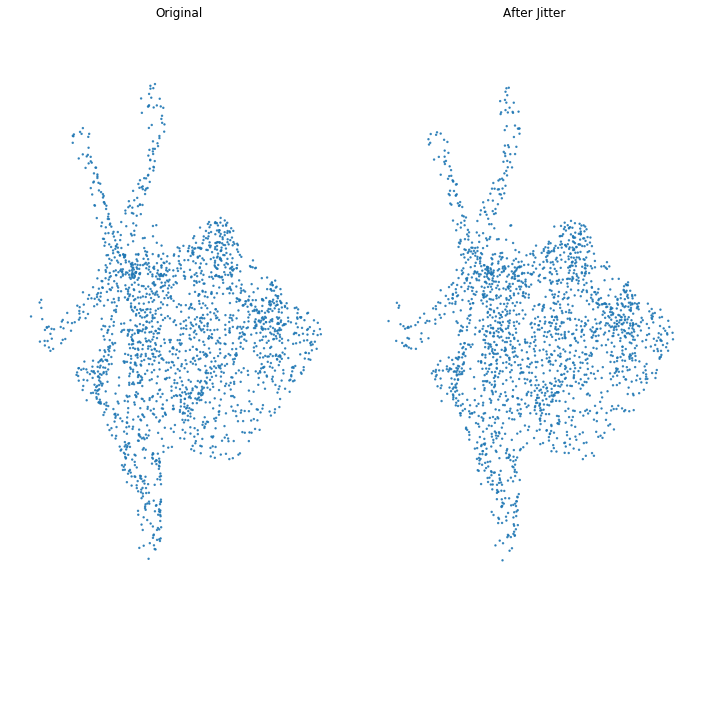

In [8]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(121, projection='3d')
_ = plot_3d_point_cloud(point_cloud_1[:, 0], point_cloud_1[:, 1], point_cloud_1[:, 2], axis=ax, azim=45)
ax.set_title('Original')

jitter = RandomJitterTransform()
point_cloud_jitter = jitter(point_cloud_1)

ax = fig.add_subplot(122, projection='3d')
_ = plot_3d_point_cloud(point_cloud_jitter[:, 0], point_cloud_jitter[:, 1], point_cloud_jitter[:, 2], axis=ax, azim=45)
ax.set_title('After Jitter')

**<font color='red'>TASK: </font>**Now your goal is to implement Random Rotation transformation. Make a random rotation of the input point cloud along ANY direction (or several directions). See code comments for details


You can remind rotation matrix here: https://www.wikiwand.com/en/Rotation_matrix#Basic_rotations.



In [9]:
import math
class RandomRotateTransform(object):
    def __init__(self):
        pass

    def __call__(self, data):
        """ Randomly rotate the point clouds to augument the dataset
            rotation is per shape based along ANY direction
            Input:
              Nx3 array, original point clouds
            Return:
              Nx3 array, rotated point clouds
        """

        # generate random angle in [0, 2pi]
        rotation_angle = np.random.uniform() * 2 * np.pi
        #rotation_angle = np.pi /4
        # https://en.wikipedia.org/wiki/Rotation_matrix
        Rz = [[math.cos(rotation_angle), -math.sin(rotation_angle),0],
             [math.sin(rotation_angle), math.cos(rotation_angle),0],
             [0,0,1]]
        Ry = [[math.cos(rotation_angle),0, math.sin(rotation_angle)],
             [0, 1,0],
             [-math.sin(rotation_angle),0,math.cos(rotation_angle)]]
        Rx = [[1,0,0],
              [0,math.cos(rotation_angle), -math.sin(rotation_angle)],
              [0,math.sin(rotation_angle), math.cos(rotation_angle)]]
        indx=np.random.randint(0,2)
        # print(indx)
        R=[Rx,Ry,Rz][indx]
        # print(R)
        rotated_data = np.matmul(data,R)

        rotated_data += data

        return np.float32(rotated_data)

Let's check your rotation transformation

Text(0.5, 0.92, 'After rotation')

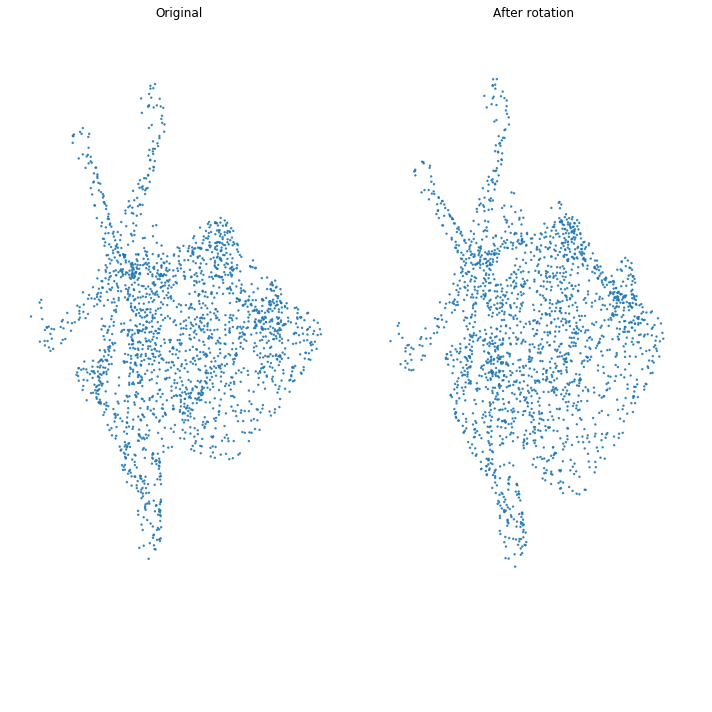

In [10]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(121, projection='3d')
_ = plot_3d_point_cloud(point_cloud_1[:, 0], point_cloud_1[:, 1], point_cloud_1[:, 2], axis=ax, azim=45)
ax.set_title('Original')

rotation = RandomRotateTransform()
point_cloud_rotated = rotation(point_cloud_1)

ax = fig.add_subplot(122, projection='3d')
_ = plot_3d_point_cloud(point_cloud_rotated[:, 0], point_cloud_rotated[:, 1], point_cloud_rotated[:, 2], axis=ax, azim=45)
ax.set_title('After rotation')

Along with the augmantation transformations we should define Scaling Transformation. It is better to make all points to be in the cube $[0, 1]$.

In [11]:
class ScaleTransform(object):
    def __init__(self):
        pass

    def __call__(self, data):
        data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
        return np.float32(data)

Now we could use all transformations together and obtrain train set and test set:

In [12]:
def get_model_net_40(datadir, batch_size, n_points):
    transform = transforms.Compose([
        RandomRotateTransform(),
        RandomJitterTransform(),
        ScaleTransform(),
    ])

    train_data = ModelNet(datadir, mode='train', n_points=n_points, transform=transform)
    test_data = ModelNet(datadir, mode='test', n_points=n_points, transform=transform)

    train_loader = torch_data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch_data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

In [13]:
train_loader, test_loader = get_model_net_40('./modelnet40-normal_numpy/', batch_size=batch_size, n_points=2048)

len(train_loader), len(test_loader)

(308, 78)

# Point Cloud Classification

Now we will solve the problem of Point Cloud classification on Model Net 40 dataset. Excluding neural network structure, there is no difference between image classification and point cloud classification.

In other words, we use well-known ingridients:


*   *Batch Stochastic Gradient Descend* optimizer (in our case I use *Adam* algorithm)
*   *Cross-Entropy* loss function
*   *Accuracy* as the measure of quality


Below I define two functions: for training and evaluation.

In [15]:
def eval_net(net, test_loader, epoch_i):
    net = net.eval()

    acc = 0
    n_pc = 0

    for batch_it, (x_tr, y_tr) in enumerate(test_loader):
        x_input = torch.FloatTensor(x_tr).to(device)
        y_input = torch.LongTensor(y_tr).to(device)

        probs = net(x_input)

        acc += (probs.data.cpu().argmax(dim=1) == y_tr).sum()
        n_pc += y_tr.shape[0]

    acc = float(acc.data.cpu().numpy()) / n_pc

    print('Test accuracy: %.2f' % acc)

def train_net(net, n_epochs, train_loader, test_loader):
    loss_func = torch.nn.CrossEntropyLoss()
    minimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    
    losses = []

    for epoch_i in range(10):
        print('EPOCH %s' % epoch_i)
        with torch.no_grad():
          eval_net(net, test_loader, epoch_i)
        net = net.train()

        acc = 0
        n_pc = 0

        for batch_it, (x_tr, y_tr) in enumerate(train_loader):
            x_input = torch.FloatTensor(x_tr).to(device)
            y_input = torch.LongTensor(y_tr).to(device)

            probs = net(x_input)

            # print(y_input, probs)
            loss = loss_func(probs, y_input).mean()

            minimizer.zero_grad()
            loss.backward()
            minimizer.step()

            acc += (probs.data.cpu().argmax(dim=1) == y_tr).sum()
            n_pc += y_tr.shape[0]

            losses.append(loss.item())

        ipython_display.display(pl.gcf())
        ipython_display.clear_output(wait=True)
        plt.title('Loss')
        plt.plot(losses)
        plt.show()

# Simple Point Cloud Network

Now it's time to implement your first neural networks for point cloud **classification**. It should be very simple.

It basically consists of three steps:

1.   Linear layer, that is **applied for each point separately**. Use here `torch.nn.Conv1d`.
2.   Get rid of `n_points` dimension. Remember permutation-invariant functions (max, sum)
3.   Linear layer 

You should obtain the following shapes:

1.   Input of shape `[batch_size, n_points, 3]`
2.   `[batch_size, n_points, 3] -> [batch_size, n_points, 64]`
3.   `[batch_size, n_points, 64] -> [batch_size, 64]`
4.   `[batch_size, 64] -> [batch_size, num_classes]`


Totally there will be $40$ classes.

## Linear transformation for each point


It is very important to notice how we work with points. Initially we have shape `[batch_size, n_points, 3]` and would like to make it `[batch_size, n_points, 64]`. In other words, we transform our 3-dimentional space into 64-dimantional space. We can do it in two ways:


1.   Use `torch.nn.Linear(3, 64)` — standard linear layer;
2.   Use `torch.nn.Con1d(3, 64, 1)` — 1d convolution with kernel size $1$, which is equivalent to the Linear layer.


The first way with linear layer is OK, but usually it is very inconvinient:



*   In order to apply BatchNorm1D to each point, you have to have shape `[batch_size, 3, n_points]`
*   I.e. you will need to transpose your tensor before each batch norm and back after it.



 More convinient will be the following pipeline:

1.   Transpose our input tensor once: `[batch_size, n_points, 3] -> [batch_size, 3, n_points]`
2.   Apply `torch.nn.Con1d(3, 64, 1)` and obtain shape `[batch_size, 64, n_points]`
3.   Apply BatchNorm1d as is along with ReLU.

The similarity and difference in `Conv1d` with kernel $1$ and `Linear` layers is described here: https://stackoverflow.com/a/56685503. TLDR: Linear layer is faster, but results are the same. I.e. you can use whatever you want, but for this tutorial Conv1D would be more convenient in terms of implementation.


You may need to recall the intefaces of [torch.Tensor.transpose](https://pytorch.org/docs/master/tensors.html#torch.Tensor.transpose), [torch.max](https://pytorch.org/docs/master/torch.html#torch.max), and [torch.sum](https://pytorch.org/docs/master/torch.html#torch.sum). Notice, that `torch.max` returns more than just values.



In [16]:
class SmallNet(nn.Module):
    def __init__(self, num_classes=40):
        super().__init__()
        self.conv1 = nn.Conv1d(3,64,1)
        self.bn1 = nn.BatchNorm1d(64)
        self.output = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = x.to(device)
        #print(x.shape)
        x = torch.Tensor.transpose(x,1,2)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #print(x.shape)
        x = torch.max(x,dim = 2).values
        #print(x.shape)
        x = self.output(x)
        
        return x               

In [17]:
# disabled to free memory
# train_net(SmallNet(40).to(device), 10, train_loader, test_loader)

This is not state-of-the-art, isn't it? Well, let's consider more advanced neural network: Point Net. 

# Point Net

Now we will consider PointNet — a neural network, that was designed for point cloud classification and segmentation problems. Now we work with classification problem, thus you are interested only in blue part of the scheme:

![alt text](http://stanford.edu/~rqi/pointnet/images/pointnet.jpg)

One can notice, that Point Net is the modification of the networks, that we built in the previous task. It has two main differences:

1.   Point Net has more learnable layers
2.   It adds so-called T-Net in order to make Point Net invariant to rotations and transformation. 

Let's take a closer look at T-Net



Good feature of Point Net — invariance to rotations. It is done using T-Net. In the original paper it is hard to understand it, but I think it is important. Thus let's drive into details.

Consider we have a point cloud $x$ --- matrix of size $2048 \times 3$. T-Net is a function of x, that returns a matrix of shape $3 \times 3$. Since all points are located in 3-dimentional space, we can consider the output of T-Net as a transformation matrix and can **multiply** it on $x$:

$$
x \leftarrow x \cdot TNet(x),
$$

where $\cdot$ stands for matrix multiplication. Here all cool stuff is hidden:


1.   We interpret $TNet(x)$ as a matrix of transformation. I.e. rotation or reflection matrix
2.   We predict it depending on the input point cloud $x$
3.   We learn the transformation during neural network training.


Let us repeat: for the input point cloud $x$ we predict its rotation matrix and apply it.



In [54]:
class TNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32)).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


Now we are ready to define Point Net. Again, our input will have shape `[batch_size, n_point, 3]`.

The structure of the network should be the following:



1.   Linear for each point (`torch.nn.Conv1d`)
2.   Batch Norm for each point
3.   ReLU for each point
4.   Linear for each point (`torch.nn.Conv1d`)
5.   Batch Norm for each point
6.   ReLU for each point
7.   Permutation-invariant operation (max, sum)
8.   Multy-layer perceptron
9.   Output size: `[batch_size, num_classes]`




In [55]:
class PointNet(nn.Module):
    def __init__(self, num_classes=40):
        super().__init__()
        self.tnet = TNet()
        self.num_classes = num_classes
        
        self.conv1 = nn.Conv1d(3,64,1)
        self.bn1 = nn.BatchNorm1d(64)
        
        self.conv2 = nn.Conv1d(64,128,1)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.conv3 = nn.Conv1d(128,1024,1)
        self.bn3 = nn.BatchNorm1d(1024)
        
        self.mlp1 = nn.Sequential(
            nn.Linear(1024,512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace = True),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace = True),
            
            nn.Linear(256, self.num_classes),
            nn.Softmax()
        )

    def forward(self, x):
        trans = self.tnet(x)
        x = torch.bmm(x, trans)
        # print(x.shape)
        
        x = torch.Tensor.transpose(x, 1, 2)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        # print(x.shape)
        
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        # print(x.shape)
        
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        # print(x.shape)
        
        x = torch.max(x,dim = 2).values
        
        # print(x.shape)
        
        x = self.mlp1(x)
        # print(x.shape)

        return x

In [56]:
net = PointNet().to(device)

# test input shape
for batch_it, (x_tr, y_tr) in enumerate(test_loader):
    sample = torch.FloatTensor(x_tr).to(device)
    out = net(sample)
    print(out.shape)
    break


torch.Size([32, 40])


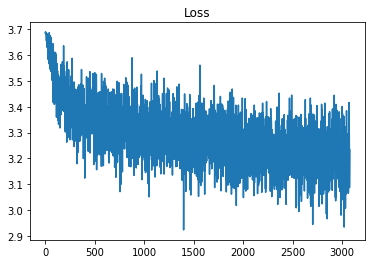

In [21]:
train_net(net.to(device), 10, train_loader, test_loader)

# Generative Learning

In this section we will build an autoencoder for Point Clouds. However, I would like to mention different problems, where you can apply autoencoder and its extentions.


## Shape Completion (aka Inpainting)

In the shape completion task your goal is to complete the point cloud with missing points. This problem is usually occurs, when the data from LIDAR is not complete.

![alt text](https://storage.googleapis.com/groundai-web-prod/media%2Fusers%2Fuser_150793%2Fproject_240441%2Fimages%2Ffigures%2Fkitti_match.png)


## Upsampling

Another quite important problem is point cloud upsampling. This is very similar to image super-resolution: the goal is to increase the density of your points.

![alt text](http://www.pointclouds.org/assets/images/contents/documentation/surface_meshing.png)


# Autoencoder

Our goal for this section is to build an autoencoder. More formally, for the input point cloud $x$ we want to build an encoder $E$ and decoder $D$ s.t. 

$$D(E(x)) \approx x$$

Here encoder $E$ and decoder $D$ are neural networks with learnable parameters. 

![alt text](https://github.com/charlesq34/pointnet-autoencoder/raw/master/doc/teaser.jpg)


https://arxiv.org/pdf/1707.02392.pdf


## Loss. Chamfer Distance

Considering images, usually autoencoder is build with minimization of $l_2$ distance: 

$$
\parallel D(E(x)) - x \parallel^2_2 \to \min
$$

This is OK for images. But this is completely not OK for point clouds. Remember, that point cloud is a set. In other words, we can permute points, and it will be the same set of points. 

Thus we need a function of two sets, that will represent, how close are they. Usually, people use Chamfer Distance or Earth mover's distance. We will consider Chamfer Distance (CD):

$$
CD(S_1, S_2) = \sum_{x\in S_1} \min_{y\in S_2} \parallel x-y \parallel_2^2 + \sum_{y\in S_2} \min_{x\in S_1} \parallel x-y \parallel_2^2
$$

Intuitively, we do the following. For each point in the first set, we find the closest point in the second set and compute a distance between them. Then we sum up these distances. Then we do the same, swapping sets (i.e. compute distances from points from the second set to the first one). Finaly, we sum up every distance.

In [57]:
class ChamferDistance(nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def pairwise_dist(self, x, y):
        xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
        rx = (xx.diag().unsqueeze(0).expand_as(xx))
        ry = (yy.diag().unsqueeze(0).expand_as(yy))
        P = (rx.t() + ry - 2 * zz)
        return P

    def batch_pairwise_dist(self, a, b):
        x, y = a, b
        bs, num_points, points_dim = x.size()
        xx = torch.bmm(x, x.transpose(2, 1))
        yy = torch.bmm(y, y.transpose(2, 1))
        zz = torch.bmm(x, y.transpose(2, 1))
        diag_ind = torch.arange(0, num_points).type(torch.cuda.LongTensor)

        rx = xx[:, diag_ind, diag_ind].unsqueeze(1).expand_as(xx)
        ry = yy[:, diag_ind, diag_ind].unsqueeze(1).expand_as(yy)
        P = (rx.transpose(2, 1) + ry - 2 * zz)
        return P

    def forward(self, input, target):
        dist = self.batch_pairwise_dist(input, target)

        values_1, indices = dist.min(dim=1)
        values_2, indices = dist.min(dim=2)

        return torch.sum(values_1, dim=1) + torch.sum(values_2, dim=1)

Now our goal is to construct two neural networks: encoder and decoder. I propose you the following.


1.   Your Encoder should be like a Point Net. It should:
          a. Be invariant to the number of input points
          b. Be invariant to the permutation among points
          c. Have botteneck size 1024
2.   Your Decoder Should obtain a vector of size 1024 and transform it into a set of points, i.e. matrix with shape `[batch_size, n_point, n_dim]`



In [63]:
class Encoder(nn.Module):
    def __init__(self, bottleneck_size):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        self.tnet = TNet()
        
        self.conv1 = nn.Conv1d(3,64,1)
        self.bn1 = nn.BatchNorm1d(64)
        
        self.conv2 = nn.Conv1d(64,128,1)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.conv3 = nn.Conv1d(128,self.bottleneck_size,1)
        self.bn3 = nn.BatchNorm1d(self.bottleneck_size)


    def forward(self, x):
        trans = self.tnet(x)
        x = torch.bmm(x, trans)
        # print(x.shape)
        
        x = torch.Tensor.transpose(x, 1, 2)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        # print(x.shape)
        
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        # print(x.shape)
        
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        # print(x.shape)
        
        x, max_idx = torch.max(x, 2)
        x = x.view(-1, self.bottleneck_size)
        
        return x, max_idx

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_point = 2048
        self.n_dim = 3
        self.input_dim = 1024
        self.hidden_dim = self.n_point*self.n_dim
        
        self.linear1 = nn.Linear(self.input_dim,self.hidden_dim)

    def forward(self, x):
        # print(x.shape)
        x = self.linear1(x)
        # print(x.shape)
        
        x = x.view(-1, self.n_point, self.n_dim)
        # print(x.shape)
        return x
        
        

In [64]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
encoder = Encoder(1024).to(device)
decoder = Decoder().to(device)
for batch_it, (x_tr, y_tr) in enumerate(test_loader):
    print("Encoder:")
    sample = torch.FloatTensor(x_tr).to(device)
    out, max_idx = encoder(sample)
    print(out.shape, max_idx.shape)
    
    print("Decoder:")
    decout = decoder(out)
    print(decout.shape)
    break


Encoder:
torch.Size([32, 1024]) torch.Size([32, 1024])
Decoder:
torch.Size([32, 2048, 3])


We again have two function for training and evaluations of our networks.

In [65]:

def eval_ae(enc, dec, test_loader, epoch_i):
    enc, dec = enc.train(), dec.train()
    loss_func = ChamferDistance()

    loss = 0
    n_pc = 0

    for batch_it, (x_tr, y_tr) in enumerate(test_loader):
        x_input = torch.FloatTensor(x_tr).to(device)
        y_input = torch.LongTensor(y_tr).to(device)

        out = dec(enc(x_input)[0])
        
        loss += loss_func(out, x_input).sum()
        n_pc += y_tr.shape[0]

    cd = float(loss.data.cpu().numpy()) / n_pc

    print('Test CD: %.2f' % cd)

    plot_two_pc(x_tr.numpy()[0], out.detach().cpu().numpy()[0], 'Original', 'Predicted')

def train_ae(enc, dec, n_epochs, train_loader, test_loader):
    loss_func = ChamferDistance()
    minimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=0.0001)
    
    losses = []

    for epoch_i in range(10):
        print('EPOCH %s' % epoch_i)

        with torch.no_grad():
          eval_ae(enc, dec, test_loader, epoch_i)
        enc, dec = enc.train(), dec.train()


        for batch_it, (x_tr, y_tr) in tqdm(train_loader):
            x_input = torch.FloatTensor(x_tr).to(device)
            y_input = torch.LongTensor(y_tr).to(device)

            out = dec(enc(x_input)[0])

            loss = loss_func(x_input, out).mean()

            minimizer.zero_grad()
            loss.backward()
            minimizer.step()

            losses.append(loss.item())

        ipython_display.display(pl.gcf())
        ipython_display.clear_output(wait=True)

        plt.title('Loss')
        print(losses)
        plt.plot(losses)
        plt.show()

In [66]:
enc = Encoder(bottleneck_size=1024).to(device)
dec = Decoder().to(device)

In [ ]:
train_ae(enc, dec, 10, train_loader, test_loader)

EPOCH 0


Now it's time to play with nice visualization. In our encoder network there is `torch.max` function, which allow us to get rid of `n_points` dimension.

Note, that not all points will play their role for the result of max function (in case of all features will be very small). Points that are important for max function, are called *critical set*. Let us visualize it.

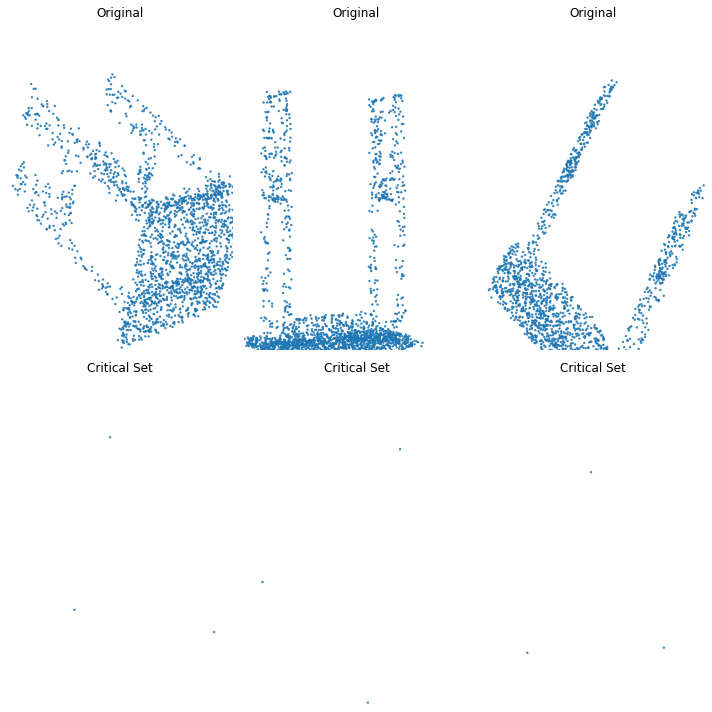

In [28]:
sample_pc, _ = next(iter(test_loader))

with torch.no_grad():
  _, max_idx = enc(sample_pc.cuda())
  max_idx = max_idx.cpu().numpy()

points_idxs = np.unique(max_idx[0])
plot_two_pc(sample_pc.numpy()[0], sample_pc.numpy()[0, points_idxs], 'Original', 'Critical Set')

Visualization from Point Net paper:

![alt text](http://stanford.edu/~rqi/pointnet/images/kp_ss_visu1.jpg)

Hope it was very useful. In case of questions feel free to contact me. 


*   Denis Volkhonskiy
*   Telegram: http://teleg.run/dvolkhonskiy
*   Email: dvolkhonskiy@gmail.com


